In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from textblob import TextBlob
import nltk
import re
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

Read the Dataset

In [62]:
dataset = pd.read_csv("Stress.csv")

Data Exploration

In [63]:
print("Rows :", dataset.shape[0])
print("Columns :", dataset.shape[1])
print()
print("Categorical columns :")
print(dataset.select_dtypes(include=['object']).apply(pd.Series.nunique, axis=0))
print()
print("Description :")
print(dataset.info())
print()
print("missing values:")
print(dataset.isnull().sum())

Rows : 2838
Columns : 7

Categorical columns :
subreddit           10
post_id           2343
sentence_range     173
text              2820
dtype: int64

Description :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB
None

missing values:
subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64


 Data Sample

In [64]:
dataset.sample()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
1682,anxiety,7ocqe2,"[5, 10]",Only self-diagnosed as OCD until my eventual d...,0,0.571429,1515173417


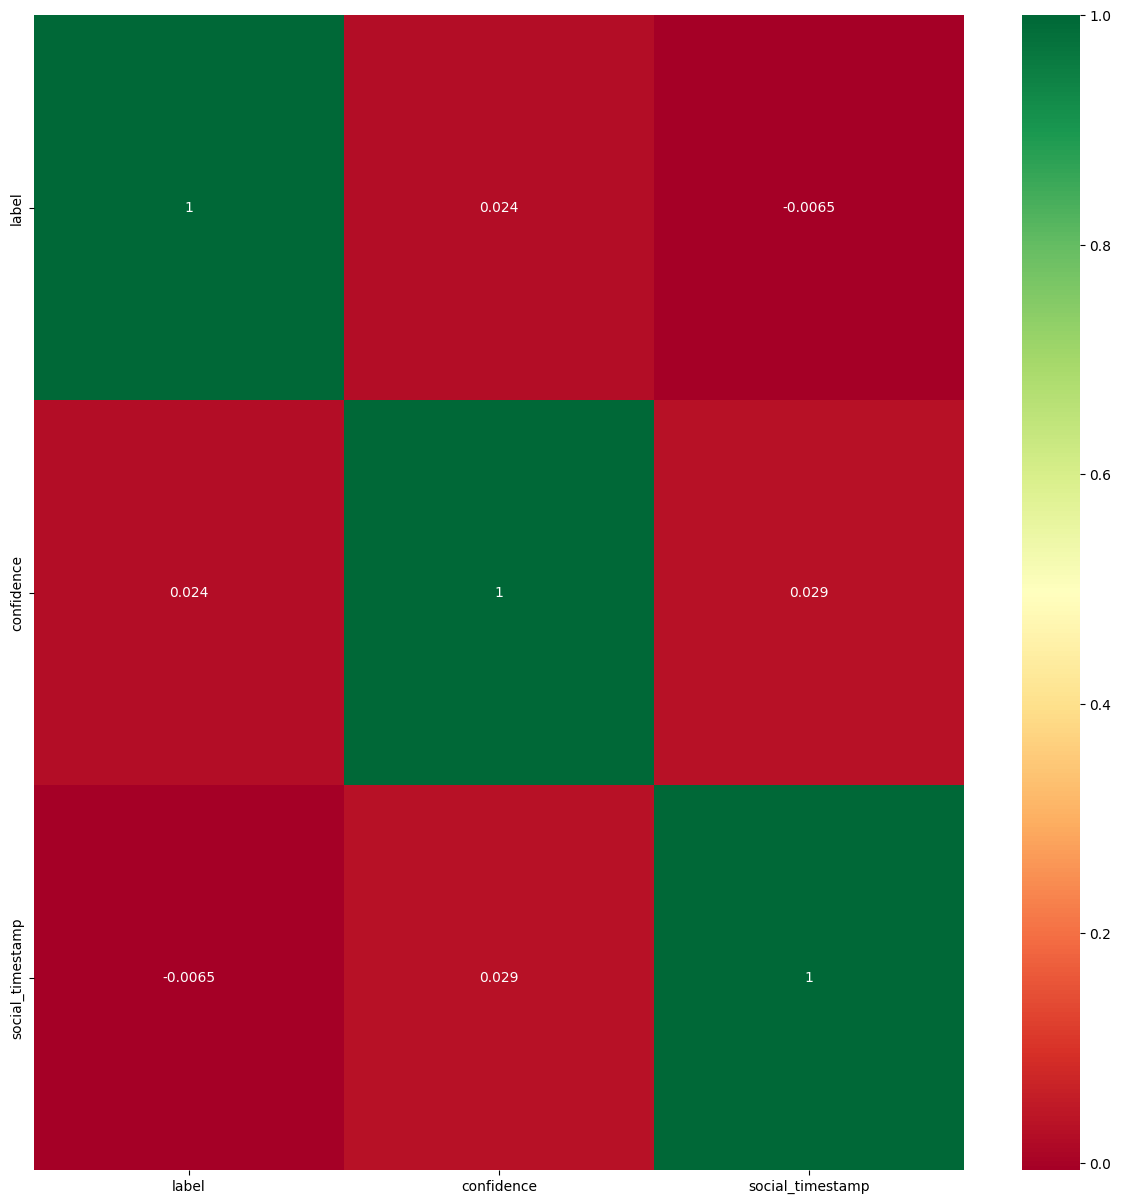

In [65]:
#CHECKING FOR CORRELATION

corrmat =dataset.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(15,15))
g=sns.heatmap(dataset[top_corr_features].corr(),annot=True, cmap="RdYlGn")

In [66]:
#Positive Sentiment
print("Positive Sentiment :")
print("Polarity : ",TextBlob("greatest").polarity)
print("Sentiment : ",TextBlob("greatest").sentiment)
print()
#Negative Sentiment
print("Negative Sentiment :")
print("Polarity : ",TextBlob("worst").polarity)
print("Sentiment : ",TextBlob("worst").sentiment)

Positive Sentiment :
Polarity :  1.0
Sentiment :  Sentiment(polarity=1.0, subjectivity=1.0)

Negative Sentiment :
Polarity :  -1.0
Sentiment :  Sentiment(polarity=-1.0, subjectivity=1.0)


In [67]:
#Sentiment Detection
def mood(txt):
    return TextBlob(txt).sentiment.polarity

In [68]:
#Get text
texts = dataset[["text"]]

In [69]:
#Adding Mood Detection as column
texts["sentiment"] = texts["text"].apply(mood)
texts.head()

,text,sentiment
0,"He said he had not felt that way before, sugge...",-0.002742
1,"Hey there r/assistance, Not sure if this is th...",0.292857
2,My mom then hit me with the newspaper and it s...,0.011894
3,"until i met my new boyfriend, he is amazing, h...",0.141671
4,October is Domestic Violence Awareness Month a...,-0.204167


In [70]:
print("Value Exploration :")
print("Minimum Sentiment :", texts["sentiment"].min())
print("Maximum Sentiment :", texts["sentiment"].max())
print()
print("Counts :")
print(texts.sentiment.value_counts())

Value Exploration :
Minimum Sentiment : -1.0
Maximum Sentiment : 1.0

Counts :
0.000000    63
0.250000    21
0.100000    19
0.175000    14
0.166667    12
            ..
0.038095     1
0.032727     1
0.166171     1
0.095833     1
0.016667     1
Name: sentiment, Length: 2137, dtype: int64


In [71]:

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
def removal(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [w for w in text.split(' ') if w not in stopwords]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
texts["text"] = texts["text"].apply(removal)
texts["text"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       said felt way before, sugget go rest ..trigger...
1       hey r/assistance, sure right place post this.....
2       mom hit newspap shock would this, know like pl...
3       met new boyfriend, amazing, kind, sweet, good ...
4       octob domest violenc awar month domest violenc...
                              ...                        
2833    * her, week ago: precious, you? (i ignor her.)...
2834    abil cope anymore. i'm trying, lot thing trigg...
2835    case first time read post... look peopl will c...
2836    find normal? good relationship. main problem s...
2837    talk mom morn said sister. trauma wors mine de...
Name: text, Length: 2838, dtype: object

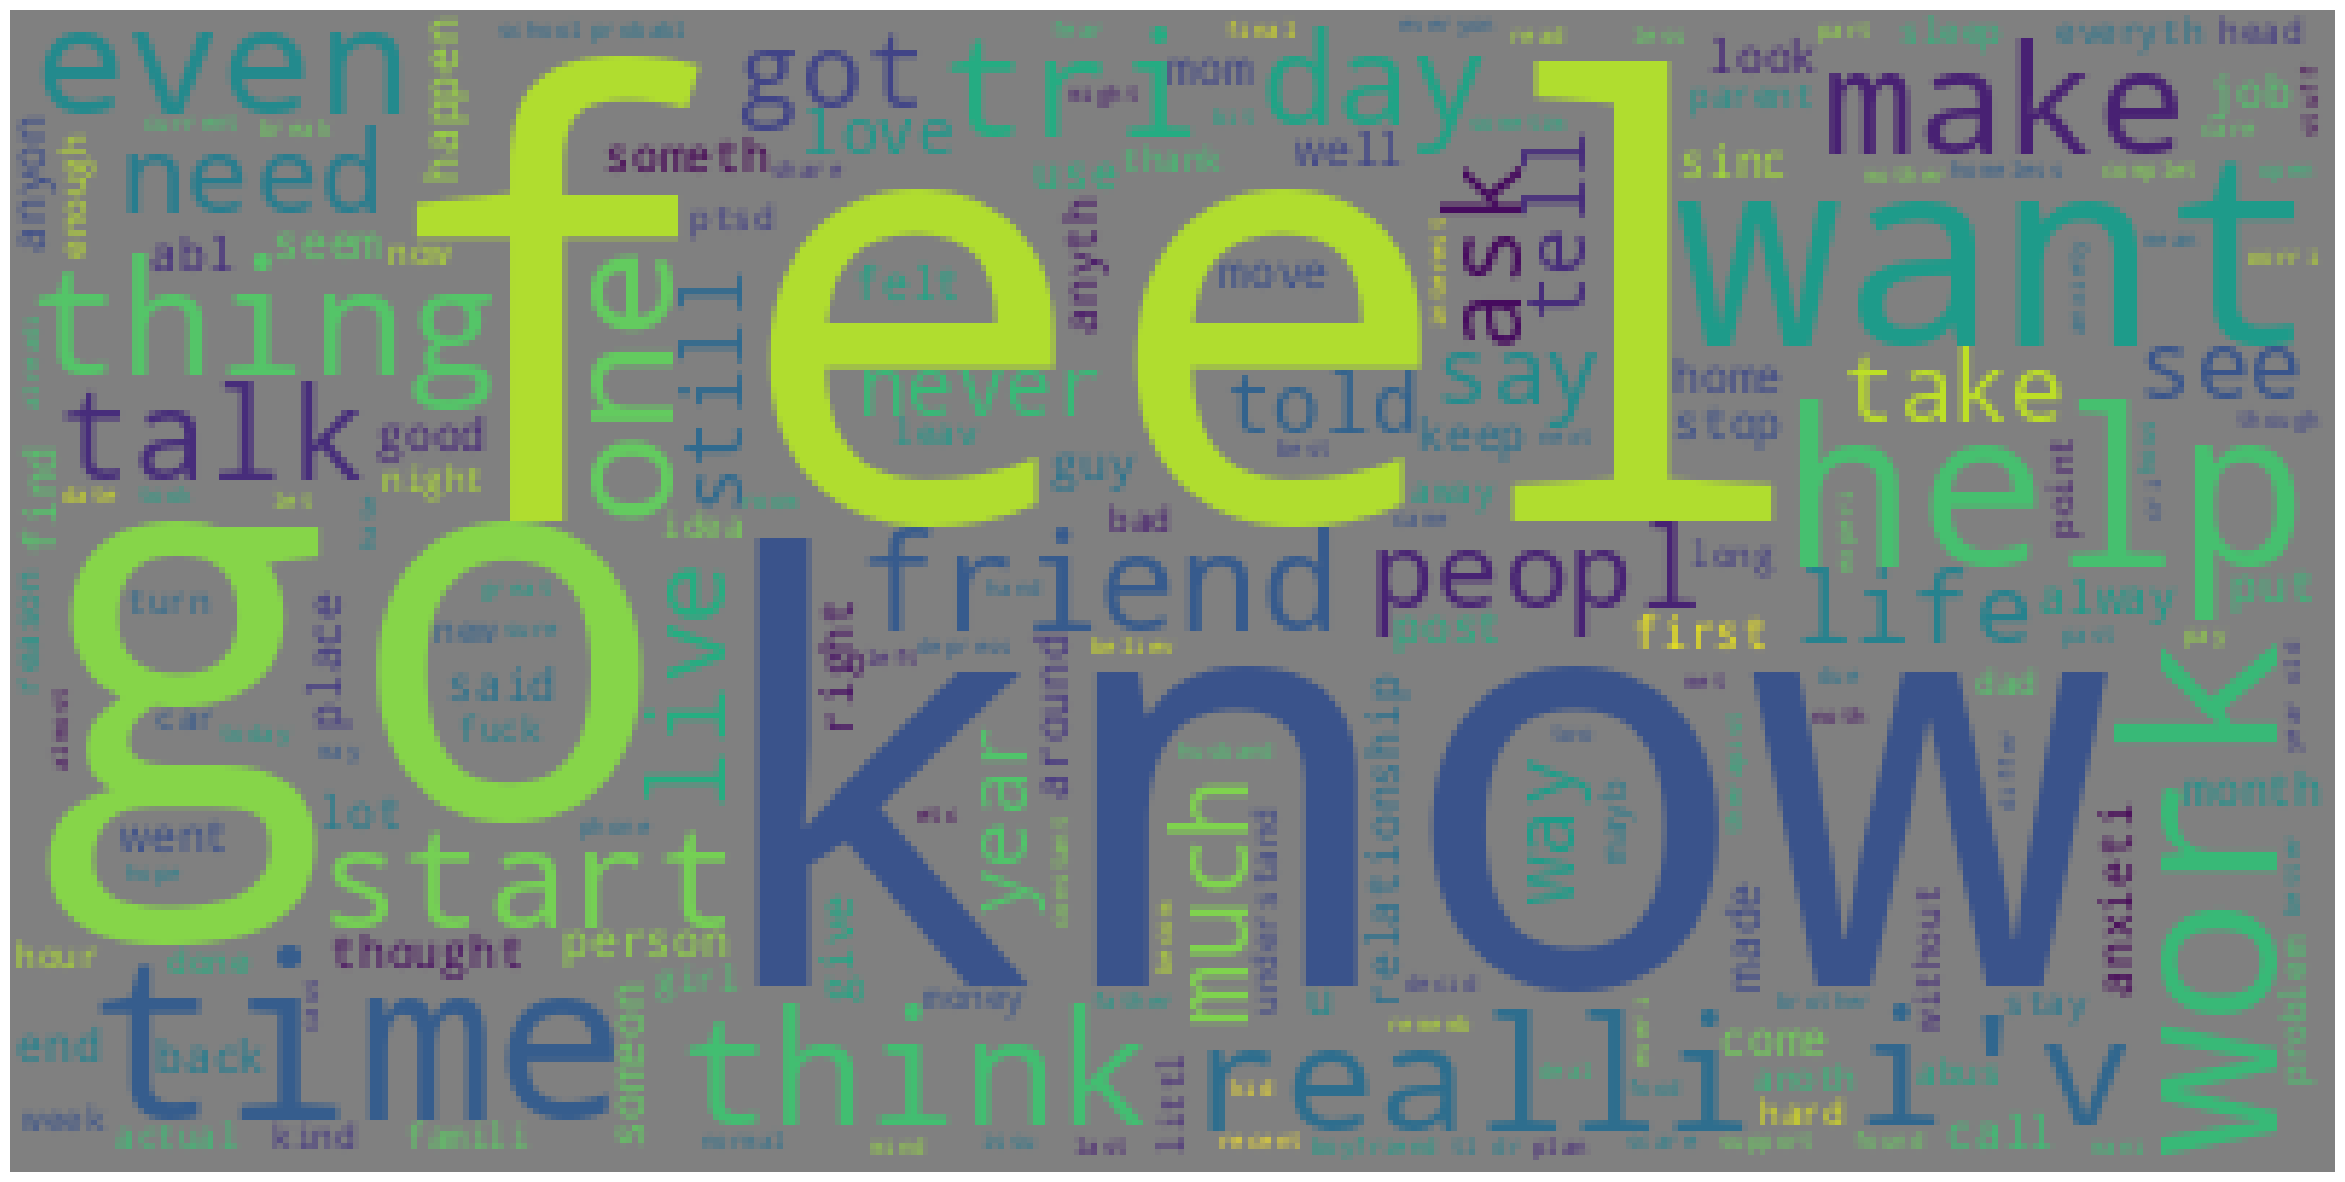

In [72]:
#Wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(30,30))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis("off")
wc(texts.text,'grey')

In [73]:
#Adding meaning to text from dataset
texts["meaning"] = dataset["label"].map({0:"Unstressed", 1:"Stressed"})
#posts = posts[["text", "meaning"]]
texts.head()

,text,sentiment,meaning
0,"said felt way before, sugget go rest ..trigger...",-0.002742,Stressed
1,"hey r/assistance, sure right place post this.....",0.292857,Unstressed
2,"mom hit newspap shock would this, know like pl...",0.011894,Stressed
3,"met new boyfriend, amazing, kind, sweet, good ...",0.141671,Stressed
4,octob domest violenc awar month domest violenc...,-0.204167,Stressed


In [74]:
#Applying sentiment
texts["sentiment"] = texts["text"].apply(mood)
texts.head()

,text,sentiment,meaning
0,"said felt way before, sugget go rest ..trigger...",0.027273,Stressed
1,"hey r/assistance, sure right place post this.....",0.360714,Unstressed
2,"mom hit newspap shock would this, know like pl...",0.199273,Stressed
3,"met new boyfriend, amazing, kind, sweet, good ...",0.190156,Stressed
4,octob domest violenc awar month domest violenc...,-0.085714,Stressed


<Axes: xlabel='meaning', ylabel='count'>

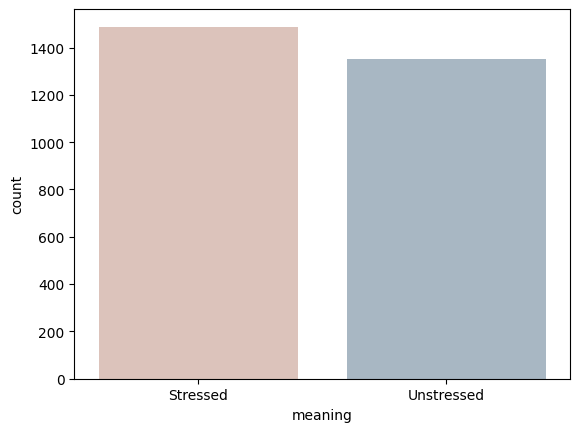

In [75]:
#sns.displot(x=posts.meaning, kind='kde')
sns.countplot(x='meaning',data = texts, palette= ["#e1c0b6", "#a3b8c8"])

Modelling 

In [76]:
#Assign variables; x = features & y = target
x = texts.text
y = texts.meaning

In [77]:
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x)

In [78]:

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=0 )

In [79]:
from sklearn.naive_bayes import MultinomialNB
mb=MultinomialNB()
mb1 = mb.fit(x_train,y_train)
mb2=mb.predict(x_test)
print("Model Accuracy is {p}%".format(p =round (accuracy_score(mb2,y_test)*100, 2)))

Model Accuracy is 73.06%


In [80]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression()
log1 = log.fit(x_train, y_train)
log2=log.predict(x_test)
# score = m2.score(x_test,y_test)
#accuracy_score(m2,y_test)
# print("Model Accuracy is {p}%".format(p =round (score*100, 2)))
print("Model Accuracy is {p}%".format(p =round (accuracy_score(y_test,log2)*100, 2)))

Model Accuracy is 73.59%


In [81]:
from sklearn.tree import DecisionTreeClassifier
d=DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
d.fit(x_train,y_train)
m3=d.predict(x_test)
print("Model Accuracy is {p}%".format(p =round (accuracy_score(y_test,m3)*100, 2)))

Model Accuracy is 63.38%


In [82]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', random_state = 43)
svc.fit(x_train,y_train)
m5 = svc.predict(x_test)
print("Model Accuracy is {p}%".format(p =round (accuracy_score(y_test,m5)*100, 2)))

Model Accuracy is 71.65%


In [83]:
#Using Naive Bayes1
prompt = "Its a beautiful day & i can't stop myself from smiling"
p = vect.transform([prompt]).toarray()
output = mb.predict(p)
print(output)

['Unstressed']


In [ ]:
#Using Naive Bayes2
prompt = "He felt underappreciated and resented his job"
p = vect.transform([prompt]).toarray()
output = mb.predict(p)
print(output)

['Stressed']


In [ ]:
#support vector machine 1
prompt = "He felt underappreciated and resented his job"
p = vect.transform([prompt]).toarray()
output = svc.predict(p)
print(output)

['Stressed']


In [ ]:
#support vector machine 2
prompt = "Its a beautiful day & i can't stop myself from smiling"
p = vect.transform([prompt]).toarray()
output = svc.predict(p)
print(output)

['Unstressed']


In [84]:
import pickle

Pkl_Filename = "Stress.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(svc, file)
    
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vect, file)

# load the model back from file

with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

SVC(kernel='linear', random_state=43)